# Libraries and Functions

In [57]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten
from sklearn.metrics import matthews_corrcoef
from tensorflow.keras.initializers import Constant
import matplotlib.pyplot as plt

In [58]:
def parse_data(file_path):
    sequences, secondary_structures = [], []
    parsing_sequences = False
    with open(file_path, "r") as file:
        sequence = ""
        secondary_structure = ""
        for line in file:
            line = line.strip()
            if line == "<>" and not parsing_sequences:
                parsing_sequences = True
            elif line == "end" or line == "<end>":
                parsing_sequences = False
                sequences.append(sequence)
                secondary_structures.append(secondary_structure)
                sequence = ""
                secondary_structure = ""
            elif parsing_sequences and line == "<>":
                sequences.append(sequence)
                secondary_structures.append(secondary_structure)
                sequence = ""
                secondary_structure = ""
            elif parsing_sequences:
                parts = line.split()
                if len(parts) == 2:
                    amino_acid, sec_structure = parts
                    sequence += amino_acid
                    secondary_structure += sec_structure
    return sequences, secondary_structures

def encode_sequences(sequences):
    # Function to one-hot encode amino acid sequences
    encoded = []
    for sequence in sequences:
        amino_acids = 'ACDEFGHIKLMNPQRSTVWY!'
        num_amino_acids = len(amino_acids)
        encoded_seq = np.zeros((len(sequence), num_amino_acids), dtype=int)
        for i, aa in enumerate(sequence):
            if aa in amino_acids:
                encoded_seq[i, amino_acids.index(aa)] = 1
        encoded.append(encoded_seq)
    return encoded

def encode_structure(structures):
    # Function to encode secondary structures
    mapping = {'-': 3, '_': 0, 'e': 1, 'h': 2}
    encoded_list = []
    for structure in structures:
        encoded_structure = [mapping[char] for char in structure]
        encoded_list.extend(encoded_structure)
    return np.array(encoded_list)

def create_windows(sequences, window_size):
    # Function to create sliding windows for input sequences
    X = []
    for sequence in sequences:
        pad_width = ((window_size // 2, window_size // 2), (0, 0))
        padded_seq = np.pad(sequence, pad_width, mode='constant')
        for i in range(len(sequence)):
            window_start = i
            window_end = i + window_size
            window = padded_seq[window_start:window_end]
            if window[window_size // 2][-1] != 1:
                X.append(window)
    return np.array(X)

def calculate_accuracy(y_true, y_pred):
    # Function to calculate accuracy
    if len(y_pred.shape) == 2:
        y_pred_labels = np.argmax(y_pred, axis=1)
    else:
        y_pred_labels = y_pred
    class_accuracies = {}
    for class_idx in range(3):
        class_pred_labels = y_pred_labels[y_true == class_idx]
        class_true_labels = y_true[y_true == class_idx]
        class_accuracy = np.sum(class_pred_labels == class_true_labels) / len(class_true_labels)
        class_names = {0: 'coil', 1: 'β-sheet', 2: 'α-helix'}
        class_accuracies[class_names[class_idx]] = class_accuracy
    for class_name, accuracy in class_accuracies.items():
        print(f"Accuracy for class {class_name}: {accuracy}")
    total_correct_predictions = np.sum(y_pred_labels == y_true)
    total_accuracy = total_correct_predictions / len(y_true)
    print("Total Accuracy:", total_accuracy)

def preprocess_data_2(predictions, window_size):
    # Function to preprocess data for second model
    sequence_length, num_classes = predictions.shape
    pad_width = ((window_size // 2, window_size // 2), (0, 0))
    windowed_predictions = np.empty((sequence_length, window_size, num_classes))
    padded_predictions = np.pad(predictions, pad_width, mode='constant')
    windows = []
    for j in range(len(padded_predictions) - window_size + 1):
        window_start = j
        window_end = j + window_size
        window = padded_predictions[window_start:window_end]
        windows.append(window)
    windowed_predictions = np.array(windows)
    return windowed_predictions

def calculate_correlation_coefficients(y_test, test_result):
    class_names = {0: 'coil', 1: 'β-sheet', 2: 'α-helix'}
    correlation_coefficients = {}
    for class_idx in range(3):
        actual_labels = (y_test == class_idx).astype(int)
        predicted_labels = (test_result == class_idx).astype(int)
        correlation_coefficient = matthews_corrcoef(actual_labels, predicted_labels)
        correlation_coefficients[class_names[class_idx]] = correlation_coefficient

    # Print correlation coefficients
    for class_name, correlation_coefficient in correlation_coefficients.items():
        print(f"MCC for class {class_name}: {correlation_coefficient}")

def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Data processing
Training and test files are preprocessed into window sizes of 13 and one-hot encoded

In [59]:
train_path = 'Q_and_s_data/protein-secondary-structure.train.txt'
test_path = 'Q_and_s_data/protein-secondary-structure.test.txt'

train_sequence, train_structure = parse_data(train_path)
test_sequence, test_structure = parse_data(test_path)

window_size = 13

X_train_encoded = encode_sequences(train_sequence)
y_train = encode_structure(train_structure)

X_test_encoded = encode_sequences(test_sequence)
y_test = encode_structure(test_structure)

X_train = create_windows(X_train_encoded, 13)
X_test = create_windows(X_test_encoded, 13)

# Model training and evaluation
Two neural networks are trained mimicking the original Qian & Sejnowski implementation.
1st is sequence-to-structure.
2nd is structure-to-structure.

In [60]:
# Define and compile the model
model = Sequential([
    Input(shape=(window_size, 21)),
    # Flatten(),
    LSTM(units=40),
    # Dense(units=40, activation='relu'),
    Dense(units=3, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history1 = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5607 - loss: 0.9456 - val_accuracy: 0.6111 - val_loss: 0.8600
Epoch 2/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6246 - loss: 0.8297 - val_accuracy: 0.6318 - val_loss: 0.8378
Epoch 3/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6381 - loss: 0.8012 - val_accuracy: 0.6295 - val_loss: 0.8345
Epoch 4/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6459 - loss: 0.7839 - val_accuracy: 0.6230 - val_loss: 0.8556
Epoch 5/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6491 - loss: 0.7720 - val_accuracy: 0.6176 - val_loss: 0.8591
Epoch 6/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6522 - loss: 0.7605 - val_accuracy: 0.6199 - val_loss: 0.8556
Epoch 7/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6686 - loss: 0.7475 - val_accuracy: 0.6227 - val_loss: 0.8510
Epoch 8/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6815 - loss: 0.7268 - val_accuracy: 0.

In [61]:
prediction_1 = model.predict(X_train)

y_pred_prob = model.predict(X_test)
X_test_2 = preprocess_data_2(y_pred_prob, 13)

X_train_2 = preprocess_data_2(prediction_1, window_size)

566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step


In [62]:
model2 = Sequential([
    Input(shape=(window_size, 3)),
    Flatten(),
    Dense(units=273, activation='relu'),
    Dense(units=3, activation='softmax')
])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the second model
history2 = model2.fit(X_train_2, y_train, epochs=10, batch_size=32, validation_data=(X_test_2, y_test))

Epoch 1/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - accuracy: 0.7052 - loss: 0.6833 - val_accuracy: 0.6324 - val_loss: 0.9155
Epoch 2/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - accuracy: 0.7293 - loss: 0.6332 - val_accuracy: 0.6330 - val_loss: 0.9084
Epoch 3/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - accuracy: 0.7302 - loss: 0.6331 - val_accuracy: 0.6247 - val_loss: 0.9065
Epoch 4/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - accuracy: 0.7251 - loss: 0.6418 - val_accuracy: 0.6298 - val_loss: 0.9020
Epoch 5/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - accuracy: 0.7305 - loss: 0.6328 - val_accuracy: 0.6193 - val_loss: 0.9086
Epoch 6/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.7409 - loss: 0.6142 - val_accuracy: 0.6205 - val_loss: 0.8990
Epoch 7/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - accuracy: 0.7358 - loss: 0.6214 - val_accuracy: 0.6315 - val_loss: 0.9106
Epoch 8/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - accuracy: 0.7358 - loss: 0.6246 - 

In [63]:
y_pred_prob2 = model2.predict(X_test_2)
y_pred_labels = np.argmax(y_pred_prob2, axis=1)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step


# Evaluation

In [64]:
calculate_accuracy(y_test, y_pred_labels)
print("")
calculate_correlation_coefficients(y_test, y_pred_labels)

Accuracy for class coil: 0.8413936557462298
Accuracy for class β-sheet: 0.3382352941176471
Accuracy for class α-helix: 0.4004711425206125
Total Accuracy: 0.628125

MCC for class coil: 0.3643313461101864
MCC for class β-sheet: 0.3069723654282157
MCC for class α-helix: 0.3307580623357184


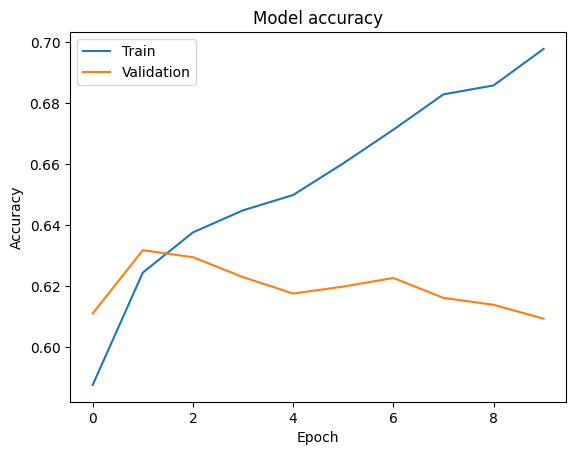

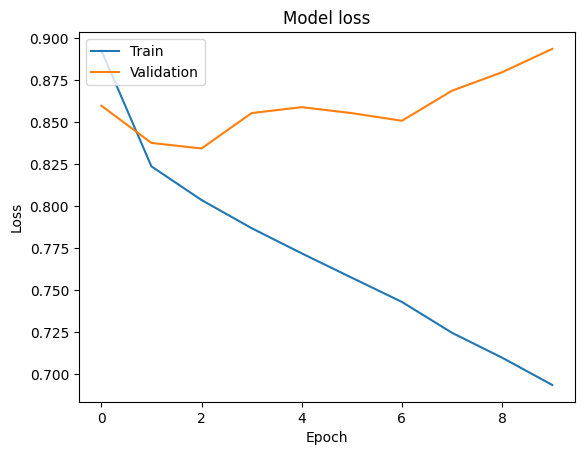

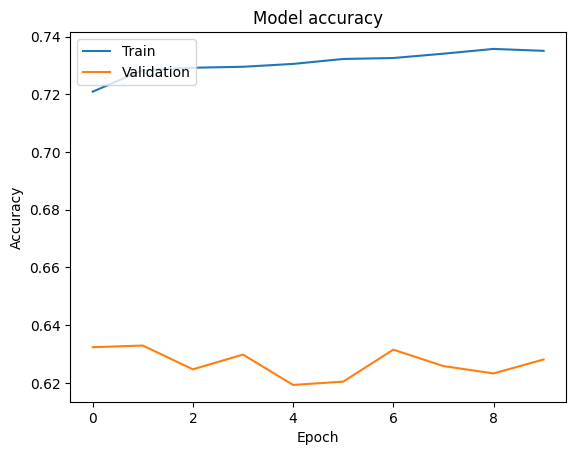

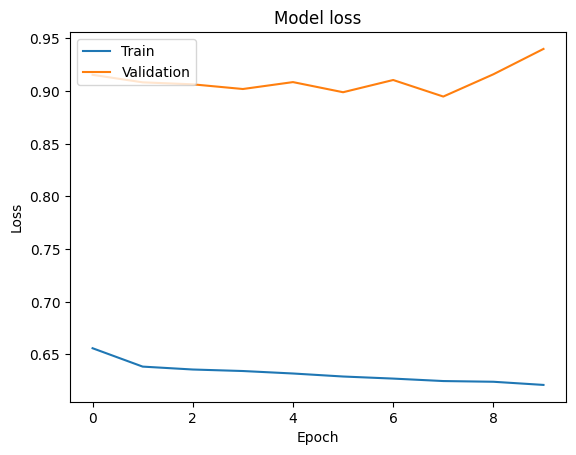

In [65]:
plot_history(history1)
plot_history(history2)